Use the tweets for the updated vocab, test classifer on humor

In [1]:
!pwd

/home/farzin/haha_2019


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
from fastai.text import *
from fastai.callbacks import SaveModelCallback
import sentencepiece as spm #https://github.com/google/sentencepiece

# Python code Examples (testing out tokenizer)

## Data

### Reading the texts

In [5]:
PATH = Path('./data/rnn/')

In [6]:
all_texts_df = pd.read_csv('./data/haha_2019_train.csv')

In [7]:
all_texts_df.head()

,id,text,is_humor,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,funniness_average
0,705196579758583809,Niveles de retraso mental: \r\n\r\n— Bajo.\r\n...,1,1,2,2,0,0,0,1.5
1,678040651817213952,"—Vamos Luke desenfunda tu sable, demuestra tu ...",1,1,3,0,1,0,0,1.5
2,546750892213829633,"- ¿Te ofrezco algo?, ¿Agua, café, mi corazón, ...",1,0,2,1,0,1,1,2.6
3,965807211292364801,No se porqué me hago la cabeza deooos,0,3,0,0,0,0,0,NaN
4,638403841839484928,Quisiera saber que hago durante la siesta de l...,0,4,0,1,0,0,0,NaN


### apply pre-rules to text

In [8]:
## New Line char for replacement in text
NL = 'xxnl'
defaults.text_spec_tok.append(NL) #add a New Line special char

def sub_nl(t:str) -> str:
    "Replaces \n by xxnl"
    return t.replace("\r\n","\n").replace("\n",NL+" ")

# def sub_br(t:str) -> str:
#     "Replaces the <br /> by \n"
#     re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
#     return re_br.sub("\n", t)

def spec_add_spaces(t:str) -> str:
    "Add spaces between special characters"
    return re.sub(r'([/#?!@,])', r' \1 ', t)

def rm_useless_spaces(t:str) -> str:
    "Remove multiple spaces"
    return re.sub(' {2,}', ' ', t)

def replace_rep(t:str) -> str:
    "Replace repetitions at the character level"
    def _replace_rep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_REP} {len(cc)+1} {c} '
    re_rep = re.compile(r'(\S)(\1{3,})')
    return re_rep.sub(_replace_rep, t)
    
def replace_wrep(t:str) -> str:
    "Replace word repetitions"
    def _replace_wrep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_WREP} {len(cc.split())+1} {c} '
    re_wrep = re.compile(r'(\b\w+\W+)(\1{3,})')
    return re_wrep.sub(_replace_wrep, t)

def deal_caps(t:str) -> str:
    "Replace words in all caps"
    res = []
    for s in re.findall(r'\w+|\W+', t):
        res += ([f' {TK_UP} ',s.lower()] if (s.isupper() and (len(s)>2)) else [s.lower()])
    return ''.join(res)

def fixup(x:str) -> str:
    "List of replacements from html strings"
    re1 = re.compile(r'  +')
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>',UNK).replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

default_rules = [fixup, replace_rep, replace_wrep, deal_caps, spec_add_spaces, 
                 rm_useless_spaces, sub_nl]

In [9]:
## apply the rules
raw_text = all_texts_df.loc[:,'text']

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")

for rule in default_rules:
    print(rule)
    raw_text = raw_text.apply(lambda x: rule(str(x)))
    
all_texts_df['new_text'] = 'xxbos ' + raw_text

Default Rules:
 ['fixup', 'replace_rep', 'replace_wrep', 'deal_caps', 'spec_add_spaces', 'rm_useless_spaces', 'sub_nl'] 


<function fixup at 0x7fc2880272f0>
<function replace_rep at 0x7fc288027158>
<function replace_wrep at 0x7fc2880271e0>
<function deal_caps at 0x7fc288027268>
<function spec_add_spaces at 0x7fc288027048>
<function rm_useless_spaces at 0x7fc2880270d0>
<function sub_nl at 0x7fc28806b2f0>


In [10]:
all_texts_df['new_text'].head()

0    xxbos niveles de retraso mental: xxnl xxnl — b...
1    xxbos —vamos luke desenfunda tu sable , demues...
2    xxbos - ¿te ofrezco algo ? , ¿agua , café , mi...
3          xxbos no se porqué me hago la cabeza deooos
4    xxbos quisiera saber que hago durante la siest...
Name: new_text, dtype: object

In [11]:
all_texts_df.shape

(24000, 11)

### Clean up the imbalanced data to balance

In [12]:
print('Number of positive samples:', (all_texts_df.is_humor == 1).sum())
print('Number of negative samples:',  (all_texts_df.is_humor == 0).sum())
print('Total samples:', len(all_texts_df))

Number of positive samples: 9253
Number of negative samples: 14747
Total samples: 24000


In [13]:
rnd_seed = 20190313
np.random.seed(rnd_seed)

idx = np.random.permutation(len(all_texts_df))
test_cut = int(0.15 * len(idx))
valid_cut = int(0.15 * len(idx-test_cut))

df_train_all = all_texts_df.iloc[idx[:-(valid_cut+test_cut)],:]
df_valid     = all_texts_df.iloc[idx[-(valid_cut+test_cut):-test_cut],:]
df_test      = all_texts_df.iloc[idx[-test_cut:],:]

In [14]:
print('Test prevalence(n = %d):'%len(df_test),df_test.is_humor.sum()/ len(df_test))
print('Valid prevalence(n = %d):'%len(df_valid),df_valid.is_humor.sum()/ len(df_valid))
print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.is_humor.sum()/ len(df_train_all))
print('all samples (n = %d)'%len(all_texts_df))
assert len(all_texts_df) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

Test prevalence(n = 3600): 0.3938888888888889
Valid prevalence(n = 3600): 0.3852777777777778
Train all prevalence(n = 16800): 0.3838095238095238
all samples (n = 24000)


In [15]:
## oversample the less-frequent occuring cases
# split the training data into positive and negative
rows_pos = df_train_all.is_humor == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]
df_train_pos.shape,df_train_neg.shape

((6448, 11), (10352, 11))

In [16]:
df_resample_pos = df_train_pos.sample(n=len(df_train_neg),replace=True,
                                      axis=0,random_state=rnd_seed).reset_index(drop=True)
df_train = pd.concat([df_resample_pos,df_train_neg],axis=0) #randomized again in DataBunch?
print('Train prevalence (n = %d):'%len(df_train), df_train.is_humor.sum()/ len(df_train))

Train prevalence (n = 20704): 0.5


### sp tokenizer from training

In [17]:
model_prefix = './all_tweets_es_0509'

In [18]:
## itos from m.vocab file: just read directly and populate the dictionary
itos = [] #{}
with open(f'{model_prefix}.vocab','r') as f:
    for line_num,line in enumerate(f):
#         itos[line_num] = line.split("\t")[0]
        itos.append(line.split("\t")[0])
        
class SPTokenizer(BaseTokenizer):
    "Wrapper around a SentncePiece tokenizer to make it a `BaseTokenizer`."
    def __init__(self, model_prefix:str):
        self.tok = spm.SentencePieceProcessor()
        self.tok.load(f'{model_prefix}.model')

    def tokenizer(self, t:str) -> List[str]:
#         return self.tok.EncodeAsIds(t)  ## tokenize + numericalize. We have them broken into two parts,just return tokens
        return self.tok.EncodeAsPieces(t)
        
class CustomTokenizer():
    '''Wrapper for SentencePiece toeknizer to fit into Fast.ai V1'''
    def __init__(self,tok_func:Callable,model_prefix:str, pre_rules:ListRules=None):
        self.tok_func,self.model_prefix = tok_func,model_prefix
        self.pre_rules  = ifnone(pre_rules,  defaults.text_pre_rules )
        
    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} using `{self.model_prefix}` model with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        return res        

    def process_text(self, t:str,tok:BaseTokenizer) -> List[str]:
        "Processe one text `t` with tokenizer `tok`."
        for rule in self.pre_rules: t = rule(t)  
        toks = tok.tokenizer(t)
    
        return toks 
    
    def _process_all_1(self,texts:Collection[str]) -> List[List[str]]:
        'Process a list of `texts` in one process'
        tok = self.tok_func(self.model_prefix)
        return [self.process_text(t,tok) for t in texts]
                                                                     
    def process_all(self, texts:Collection[str]) -> List[List[str]]: 
        "Process a list of `texts`."                                 
        return self._process_all_1(texts)

In [19]:
itos[-10:]

['→', '😫', '🤨', '😲', '🏟', '📖', '🎸', '🏿', '😮', '🎬']

In [20]:
mycust_tok = CustomTokenizer(SPTokenizer,model_prefix,pre_rules=default_rules)
sp_vocab = Vocab(itos)

In [21]:
data = TextClasDataBunch.from_df(PATH,df_train,df_valid,df_test,
                               tokenizer=mycust_tok, vocab=sp_vocab,
                               text_cols='new_text', label_cols='is_humor')

In [22]:
data.show_batch(10)  #less xxunk, but still a fair amount...

text,target
▁ xxbos ▁ xxbos ▁❤ .- ~ * ( ▁? ▁el ▁di vo 00 ▁d 3 ▁tw 1 tter ▁! ▁! ▁! ▁? ▁? ▁~ k 3 ▁di 4 vl 0 zz ▁ki 3 r 3 z ▁k 3 ▁p 4 rt 3 ▁d 3 ▁no 00 ▁n 0 ▁3 nt 13 nd 3 z ▁b 3 the ▁k 0 n ▁ki 3 n ▁t 3 ▁d 3 ▁l 4,0
▁ xxbos ▁ xxbos ▁❤ ️ -( el ▁di vo 00 ▁d 3 ▁tw 1 tter ▁! ▁! ▁? ▁i 0 ▁zo i ▁tu ▁ma 3 zt lo ▁? ▁ki 3 n ▁z up 0 ▁3 nz 3 ñ 4 l th 3 ▁? ▁d 3 ▁tu ▁k cuer p 0 ▁io o ▁k 0 noz ko ▁az t 4 ▁la ▁maz ▁in ty ma ▁p 4 r te ▁?,0
▁ xxbos ▁ xxbos ▁—¡ idio ta ▁! ▁ xxnl ▁—¡ h ist érica ▁! ▁ xxnl ▁— que ▁tarado . xxnl ▁— tar ada ▁tú . xxnl ▁— te ▁odio . xxnl ▁— yo ▁también . xxnl ▁— ▁¡ ▁ xxup ▁jode te ▁! ▁ xxnl ▁— no ▁me ▁hables . xxnl ▁—¡ ok ▁! ▁ xxnl ▁—¡ ok ▁! ▁ xxnl ▁— te ▁amo . xxnl ▁— yo,0
"▁ xxbos ▁ xxbos ▁¡ ya ▁llegó ▁santa ▁! ▁ xxnl ▁ xxunk _ xxunk xxnl ▁( ・ xxunk ・ ) xxnl ▁_ | ▁ xxunk / ( ___ ▁ xxnl ▁/ ▁l ▁( __ __ / xxnl ▁ xxnl ▁ah ▁no ▁, ▁es ▁mi ▁papá ▁bien ▁pedo . xxnl ▁ xxnl ▁< xxunk / xxunk - xxunk ___ xxnl ▁/ < _ ▁/ ▁ xxrep ▁4 ▁_ ▁/ ”",1
"▁ xxbos ▁ xxbos ▁¡ ya ▁llegó ▁santa ▁! ▁ xxnl ▁ xxunk _ xxunk xxnl ▁( ・ xxunk ・ ) xxnl ▁_ | ▁ xxunk / ( ___ ▁ xxnl ▁/ ▁l ▁( __ __ / xxnl ▁ xxnl ▁ah ▁no ▁, ▁es ▁mi ▁papá ▁bien ▁pedo . xxnl ▁ xxnl ▁< xxunk / xxunk - xxunk ___ xxnl ▁/ < _ ▁/ ▁ xxrep ▁4 ▁_ ▁/ ”",1
▁ xxbos ▁ xxbos ▁( ▁ xxup ▁o _ o ) ▁( xxunk _ ▁ xxunk ) ▁( ▁ xxup ▁o _ o ) ▁( xxunk _ ▁ xxunk ) ▁( ▁ xxup ▁o _ o ) ▁( xxunk _ ▁ xxunk ) ▁( ▁ xxup ▁o _ o ) ▁( xxunk _ ▁ xxunk ) ▁( xxunk _ ▁ xxunk ). ▁yo ▁con ▁el ▁móvil ▁en ▁clase .,1
"▁ xxbos ▁ xxbos ▁— cuel ga ▁tú . xxnl ▁— no ▁, ▁cuelga ▁tú . ▁ xxnl ▁— no ▁, ▁tú . xxnl ▁— que ▁t ... xxnl ▁—¡ ▁ xxup ▁pinche ▁ xxup ▁tonta ▁me ▁ xxup ▁colgó ▁! ▁ xxnl ▁—¡ te ▁ xxup ▁escuché ▁ xxup ▁pendejo ▁! ▁ xxnl ▁— ▁ xxup ▁jajaj á ▁¡ ay ▁amor ▁! ▁es ▁broma ▁, ▁te ▁amo .",1
"▁ xxbos ▁ xxbos ▁ xxup ▁tengo ▁un ▁ xxup ▁gran ▁ xxup ▁anuncio ▁, ▁ xxup ▁una ▁ xxup ▁noticia ▁ xxup ▁que ▁ xxup ▁cambiará ▁la ▁ xxup ▁historia ▁de ▁ xxup ▁twitter ▁, ▁ xxup ▁que ▁ xxup ▁devolver á ▁el ▁ xxup ▁sentido ▁a ▁ xxup ▁nuestra ▁ xxup ▁vida . xxnl ▁ xxnl ▁ xxup ▁pendientes ▁ xxup ▁hoy ▁en ▁la ▁ xxup ▁noche",0
"▁ xxbos ▁ xxbos ▁— mamá ▁, ▁¿ puedo ▁salir ▁? ▁— no . ▁—¿ me ▁das ▁un ▁calce tín ▁? ▁— ok ▁, ▁toma . ▁— el ▁ xxup ▁amo ▁le ▁ha ▁ xxup ▁dado ▁a ▁ xxup ▁dob by ▁un ▁ xxup ▁calce tín ... ▁¡ ▁ xxup ▁dob by ▁es ▁ xxup ▁libre ▁! ▁# ▁ xxup ▁jajaja ▁# ▁ xxup ▁hp quo tes ▁# ▁xd",1
"▁ xxbos ▁ xxbos ▁—¿ maestro ▁entonces ▁ya ▁aprobé ▁? ▁ xxnl ▁ xxnl ▁( • ▁- ▁• ) ▁ xxnl ▁ xxunk ▁ xxunk ▁ xxunk ▁__ ( • ▁- ▁• ) ▁ xxnl ▁_ xxunk ▁_ xxunk ▁ xxunk ▁ xxunk ▁ xxnl ▁ xxnl ▁—¡ hija ▁, ▁yo ▁soy ▁el ▁conser je ▁! ▁ xxnl ▁ xxnl ▁—¡ ay ▁, ▁por ▁no ▁poner ▁atención ▁!",1


### Check `xxunk` fraction on humor data

In [23]:
pct_xxunk = pd.Series([sum(y==0)/len(y) for y in [x.data for x in data.train_dl.x]])
pct_xxunk[pct_xxunk>0].shape, pct_xxunk.shape

((498,), (20704,))

In [24]:
498/20704.

0.024053323029366306

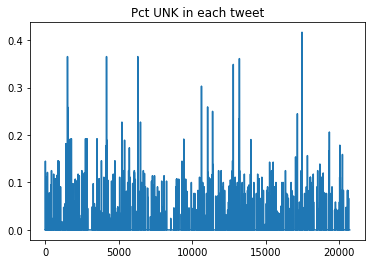

In [25]:
pd.Series([sum(y==0)/len(y) for y in [x.data for x in data.train_dl.x]]).plot()
_ = plt.title('Pct UNK in each tweet')

### build and train model

In [26]:
class m_MultiHeadAttention(nn.Module):
    "MutiHeadAttention."
    
    def __init__(self, n_heads:int, d_model:int, d_head:int=None, resid_p:float=0.1, attn_p:float=0.1, bias:bool=True,
                 scale:bool=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.attention = nn.Linear(d_model, 3 * n_heads * d_head, bias=bias)
#         self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(attn_p),nn.Dropout(resid_p)
#         self.ln = nn.LayerNorm(d_model)
        
    def forward(self, x:Tensor, mask:Tensor=None, **kwargs):
        attn_out = self._apply_attention(x, mask=mask, **kwargs)
        return attn_out
#         return self.out(attn_out)
    
    def _apply_attention(self, x:Tensor, mask:Tensor=None):
        bs,x_len = x.size(0),x.size(1)
        wq,wk,wv = torch.chunk(self.attention(x), 3, dim=-1)
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv))
        wq,wk,wv = wq.permute(0, 2, 1, 3),wk.permute(0, 2, 3, 1),wv.permute(0, 2, 1, 3)
        attn_score = torch.matmul(wq, wk)
        if self.scale: attn_score = attn_score.div_(self.d_head ** 0.5)
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = torch.matmul(attn_prob, wv)
        return attn_vec.permute(0, 2, 1, 3).contiguous().contiguous().view(bs, x_len, -1)
    
from fastai.text.learner import _model_meta

class AttnLinearClassifier(nn.Module):
    "Create a linear classifier with pooling."

    def __init__(self, layers:Collection[int], drops:Collection[float]):
        super().__init__()
        mod_layers = []
        n_heads = 5
        d_head = 20
        mod_layers = bn_drop_lin(n_heads * d_head,layers[-1], p=0.1, actn=None) # [nn.Linear(n_heads * d_head,layers[-1])]
        self.layers = nn.Sequential(*mod_layers)

        self.mhra = m_MultiHeadAttention(n_heads=n_heads,d_model=400,d_head=d_head) #emb_sz == d_model
        self.mask = False  #we are not translating, so looking "ahead" can't really happen.  
        
    def forward(self, input:Tuple[Tensor,Tensor, Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask = input
        output = outputs[-1]  #final layer of RNN stack : emb_sz dim is output by default
        
        ## this probably makes more sense to be triu rather than whatever is incoming (?)
        x_len = output.size(1)
        att_mask = torch.triu(output.new_ones(x_len, x_len), diagonal=1).byte()[None,None] if self.mask else None
        x = self.mhra(output, mask=att_mask)
        sum_attn_dim = x.masked_fill(mask[:,:,None], 0).sum(dim=1)
        x = self.layers(sum_attn_dim)
        
        return x, raw_outputs, outputs

    
def m_get_text_classifier(arch:Callable, vocab_sz:int, n_class:int, bptt:int=70, max_len:int=20*70, config:dict=None, 
                        drop_mult:float=1., lin_ftrs:Collection[int]=None, ps:Collection[float]=None,
                        pad_idx:int=1) -> nn.Module:
    "Create a text classifier from `arch` and its `config`, maybe `pretrained`."
    meta = _model_meta[arch]
    config = ifnone(config, meta['config_clas'].copy())
    for k in config.keys(): 
        if k.endswith('_p'): config[k] *= drop_mult
    if lin_ftrs is None: lin_ftrs = [50]
    if ps is None:  ps = [0.1]
#     layers = [config[meta['hid_name']] * 3] + lin_ftrs + [n_class]  #last, max, avg pool
    layers = [config[meta['hid_name']] ] + lin_ftrs + [n_class]
    ps = [config.pop('output_p')] + ps
    init = config.pop('init') if 'init' in config else None
    encoder = MultiBatchEncoder(bptt, max_len, arch(vocab_sz, **config), pad_idx=pad_idx)
    if init: encoder.apply(init)
    model = SequentialRNN(encoder, AttnLinearClassifier(layers, ps))
    return model #if init is None else model.apply(init)

def m_text_classifier_learner(data:DataBunch, arch:Callable, bptt:int=70, max_len:int=70*20, config:dict=None, 
                            pretrained:bool=True, drop_mult:float=1., lin_ftrs:Collection[int]=None, 
                            ps:Collection[float]=None, **learn_kwargs) -> 'TextClassifierLearner':
    "Create a `Learner` with a text classifier from `data` and `arch`."
    model = m_get_text_classifier(arch, len(data.vocab.itos), data.c, bptt=bptt, max_len=max_len,
                                config=config, drop_mult=drop_mult, lin_ftrs=lin_ftrs, ps=ps)
    meta = _model_meta[arch]
    learn = RNNLearner(data, model, split_func=meta['split_clas'], **learn_kwargs)
    
    return learn    

In [46]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = False
config['n_hid'] = 2304

learn = m_text_classifier_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False,
                                      config=config)
learn.load_encoder('twitter_es_enc_RNN_0510')
learn.freeze()

In [32]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


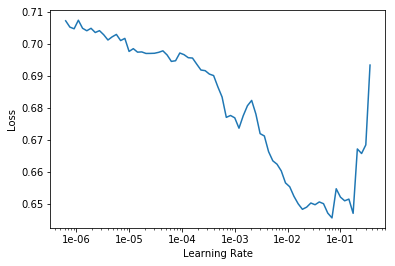

In [34]:
learn.recorder.plot(skip_end=10)

In [47]:
learn.freeze()
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.6), pct_start=1.0)
#                    callbacks=[SaveModelCallback(learn,every='improvement',mode='max',monitor='accuracy',name='best_acc_model')])

epoch,train_loss,valid_loss,accuracy,time
0,0.547974,0.406650,0.827222,00:27
1,0.497167,0.427650,0.825833,00:31
2,0.493563,0.425515,0.828333,00:28
3,0.457718,0.420194,0.831944,00:30
4,0.471854,0.402615,0.839167,00:31


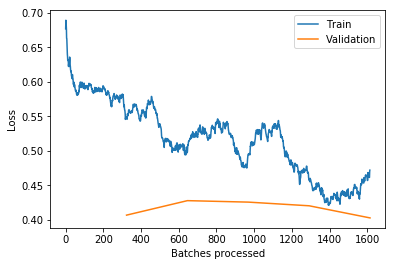

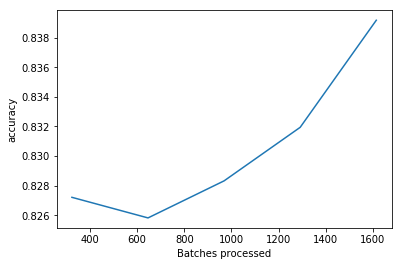

In [48]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [49]:
learn.save('rnn_trained_attn_head')

In [50]:
#learn = learn.load('rnn_trained_head')

In [51]:
learn.freeze_to(-2)
learn.fit_one_cycle(10,slice(1e-3/(2.6**2),1e-2), moms=(0.8,0.6), pct_start=1.0)
#                  callbacks=[SaveModelCallback(learn,every='improvement',mode='max',monitor='accuracy',name='best_acc_model')])

epoch,train_loss,valid_loss,accuracy,time
0,0.403559,0.386557,0.839722,00:22
1,0.384360,0.415722,0.837500,00:21
2,0.350137,0.421992,0.840278,00:19
3,0.333033,0.449440,0.839722,00:19
4,0.319181,0.444462,0.841111,00:20
5,0.286089,0.490217,0.839722,00:21
6,0.252801,0.522212,0.839722,00:20
7,0.252610,0.538934,0.838056,00:19
8,0.220345,0.559728,0.841111,00:20
9,0.231949,0.554752,0.829444,00:19


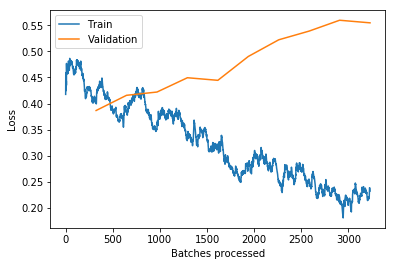

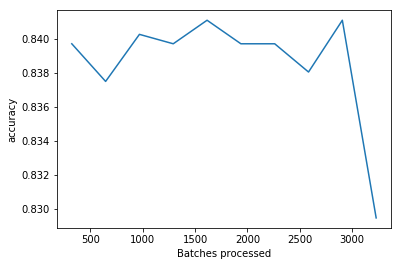

In [52]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(5,slice(5e-4/(2.6**3),5e-4),moms=(0.7,0.4), wd=0.10,
                   callbacks=[SaveModelCallback(learn,every='improvement',mode='max',monitor='accuracy',name='best_acc_model')])

In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5,slice(1e-4/(2.6**4),1e-4),moms=(0.7,0.4),
                   callbacks=[SaveModelCallback(learn,every='improvement',mode='max',monitor='accuracy',name='best_acc_model')])

In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

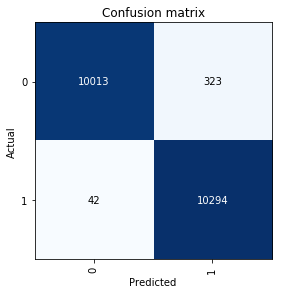

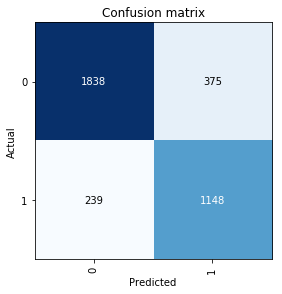

In [53]:
preds_t,y_t,losses_t = learn.get_preds(DatasetType.Train,with_loss=True)
interp_t = ClassificationInterpretation(learn, preds_t, y_t, losses_t)
interp_t.plot_confusion_matrix()

preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

In [54]:
from fastai.text.models.awd_lstm import TextClassificationInterpretation
from matplotlib.pyplot import cm
txt_ci = TextClassificationInterpretation.from_learner(learn)
(_,idxs) = interp.top_losses(5)
for idx in to_np(idxs):
    print("-"*10)
    txt_ci.show_intrinsic_attention(df_train.iloc[idx,1],cmap=cm.Blues) #textify breaks?

----------


----------


----------


----------


----------


In [41]:
learn.save("haha_20190516_tweet_vocab")

### Save predictions for use in Ensemble method (not used)

In [44]:
pd.DataFrame(to_np(preds)).to_csv('rnn_sent_preds.csv')

In [49]:
## fastai "test" has no labels.  It is a true test, not a whitholding set!!  We need a second valid set?
## move the df_test into the "valid" position so we can run inference and get preds on randomized vals
data_t = TextClasDataBunch.from_df(PATH,df_train,df_test,
                               tokenizer=mycust_tok, vocab=sp_vocab,
                               text_cols='new_text', label_cols='is_humor')
learn.data = data_t
t_preds,t_y,t_losses = learn.get_preds(with_loss=True,ds_type=DatasetType.Valid)

In [50]:
pd.DataFrame(to_np(t_preds)).to_csv('rnn_sent_t_preds.csv')